In [ ]:
import os 
import numpy as np 
import pandas as pd 
import zipfile 
from sklearn.utils import resample
import tensorflow as tf 
from tensorflow import keras 
from sklearn.pipeline import Pipeline
import re
import string
import gensim
from nltk import sent_tokenize
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
import numpy as np

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading the reviews and other details into a dataframe. 

In [ ]:
zf = zipfile.ZipFile('/content/gdrive/MyDrive/amazon_reviews.zip') 
df = pd.read_csv(zf.open('Reviews.csv'))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

Checking for null values.

In [ ]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Handling null values and combining the review title and content into one column called "Review".

In [ ]:
df.ProfileName.fillna(value = "", inplace = True)
df.Summary.fillna(value = "", inplace = True)
df["Reviews"] = df["Summary"] + " " + df["Text"]

Visualising the distribution of ratings(between 1-5). 

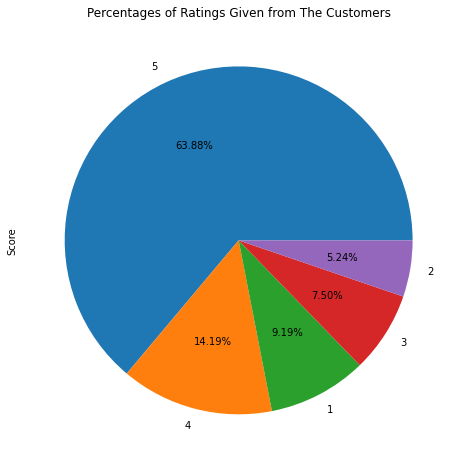

In [ ]:
import matplotlib as plt
import matplotlib.pyplot as plt
df.Score.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()

Function to encode the numerical ratings as positive,negative or neutral sentiments.  

In [ ]:
def identify_sentiment(val):
  if (val<3):
    entry='negative'
  elif (val==3):
    entry='neutral'
  else:
    entry='positive'
  return entry

df['Sentiment']= df['Score'].apply(lambda x: identify_sentiment(x))

Visualising the distribution of sentiments in our data. 

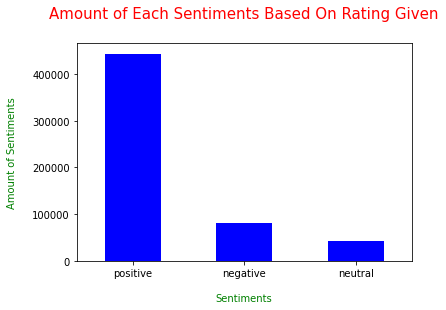

In [ ]:
df["Sentiment"].value_counts().plot(kind = "bar", color = "blue")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.show()

In [ ]:
df["Sentiment"].value_counts()

positive    443777
negative     82037
neutral      42640
Name: Sentiment, dtype: int64

We can see that there are not a significant number of neutral sentiment reviews in our data so we shall be dropping them and working with only reviews that have been identified as having positive or negative sentiment. 

In [ ]:
df.drop(df.index[df['Sentiment'] == 'neutral'], inplace=True)

In [ ]:
df["Sentiment"].value_counts()

positive    443777
negative     82037
Name: Sentiment, dtype: int64

Function to remove capital letters,remove punctuation,special characters and remove words that contain numbers. 

In [1]:
def clean_text(text):
     
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['Cleaned_1']=df['Reviews'].apply(lambda x: clean_text(x))
df['Cleaned_1'].head(10)

NameError: ignored

We need to keep only the relevant columns of text and review sentiment in the dataframe for training. 

In [ ]:
df1 = df[['Sentiment','Cleaned_1']]
df1.shape

(525814, 2)

Function to remove stopwords from the texts of the reviews.(Stopwords refers to filler words that generally do not contribute much to semantic meaning, and hence can be removed) 

In [ ]:

stop_words = frozenset({'mill', 'back', 'from', 'onto', 'ever', 'upon', 'because', 'co', 'would', 'during', 'nobody', 'i', 'until', 'bottom', 
                         'please', 'than', 'eight', 'do', 'everything', 'or', 'system', 'ie', 'is', 'our', 'every', 'nevertheless', 'un', 
                         'always', 'what', 'am', 'whose', 'before', 'may', 'inc', 'herein', 'many', 'only', 'something', 'mostly', 'such', 'describe', 
                         'get', 'together', 'latter', 'their', 'third', 'most', 'enough', 'which', 'serious', 'empty', 'ours', 'per', 'ten', 'he', 
                         'and', 'twenty', 'by', 'several', 'why', 'nothing', 'itself', 'mine', 'due', 'must', 'hence', 'all', 'becomes', 'within', 
                         'someone', 'neither', 'whether', 'same', 'forty', 'well', 'wherein', 'de', 'via', 'sixty', 'con', 'toward', 'indeed', 'we', 
                         'hasnt', 'next', 'who', 'first', 'the', 'her', 'eg', 'beside', 'latterly', 'fifty', 'thin', 'that', 'so', 'whereafter', 
                         'however', 'between', 'cry', 'can', 'with', 'you', 'part', 'keep', 'eleven', 'to', 'these', 'find', 'wherever', 
                         'has', 'also', 'anyway', 'therein', 'hereupon', 'it', 'himself', 'another', 'fill', 'seeming', 'anyone', 'less', 
                         'afterwards', 'she', 'its', 'then', 'whereby', 'see', 'whoever', 'six', 'there', 'will', 'against', 'without', 'whole', 'now',
                         'everyone', 'perhaps', 'move', 'any', 'of', 'already', 'formerly', 'hers', 'him', 'ltd', 'into', 'put', 'both', 'becoming',
                         'should', 'whenever', 'amoungst', 'somehow', 'three', 'how', 'was', 'amount', 'yourselves', 'themselves', 'often', 'up', 
                         'side', 'otherwise', 'be', 'whatever', 'sincere', 'seems', 'out', 'two', 'hundred', 'interest', 'everywhere', 'other', 
                         'where', 'off', 'nor', 'else', 'top', 'cant', 'might', 'except', 'amongst', 'on', 'anywhere', 'others', 'detail', 'name', 
                         'take', 'thence', 'whence', 'though', 'behind', 'more', 'my', 'beforehand', 'seem', 'thick', 'thru', 'sometime', 'somewhere',
                         'fifteen', 'meanwhile', 'thereafter', 'almost', 'done', 'yourself', 'seemed', 'as', 'bill', 'made', 'some', 'very', 'along', 
                          'above', 'ourselves', 'them', 'elsewhere', 'anything', 'none', 'are', 'once', 'nine', 'too', 'hereby', 'five',
                         'show', 'rather', 'through', 'below', 'yours', 'thereby', 'call', 'have', 'twelve', 'thereupon', 'when', 'own', 'after', 
                         'thus', 'front', 'down', 'namely', 'here', 'herself', 'either', 'myself', 'alone', 'whom', 'become', 'therefore', 'his',
                         'me', 'least', 'whereupon', 'for', 'a', 'anyhow', 'even', 'under', 'besides', 'etc', 'give', 'few', 'go', 'they', 'among', 
                         'full', 'were', 'former', 'us', 'four', 'much', 'hereafter', 'while', 'further', 'became', 'each', 'those', 'been', 'around', 
                         'being', 'since', 'towards', 're', 'nowhere', 'your', 'sometimes', 'whereas', 'noone', 'yet', 'throughout', 'over', 'found',
                         'although', 'at', 'across', 'moreover', 'couldnt', 'fire', 'about', 'last', 'had', 'an', 'one', 'but', 'again', 'this', 
                         'whither', 'in', 'if', 'beyond', 'still'})


def remove_stopwords(text):
  words = [word for word in text.split() if word not in stop_words]
  new_text = " ".join(words)
  return new_text

df1['Stopwords']=df1['Cleaned_1'].apply(lambda x: remove_stopwords(x))
df1.shape



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(525814, 3)

Encoding the positive reviews with 1 and the negative ones with 0.

In [ ]:
def sentiment_rating(val):
  if (val=='positive'):
    entry=1
  else:
    entry=0
  return entry

df1['Sentiment_rating']= df1['Sentiment'].apply(lambda x: sentiment_rating(x))
df1.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Sentiment,Cleaned_1,Stopwords,Sentiment_rating
0,positive,good quality dog food i have bought several of...,good quality dog food bought vitality canned d...,1
1,negative,not as advertised product arrived labeled as j...,not advertised product arrived labeled jumbo s...,0
2,positive,delight says it all this is a confection that ...,delight says confection centuries light pillow...,1
3,negative,cough medicine if you are looking for the secr...,cough medicine looking secret ingredient robit...,0
4,positive,great taffy great taffy at a great price ther...,great taffy great taffy great price wide assor...,1
5,positive,nice taffy i got a wild hair for taffy and ord...,nice taffy got wild hair taffy ordered pound b...,1
6,positive,great just as good as the expensive brands th...,great just good expensive brands saltwater taf...,1
7,positive,wonderful tasty taffy this taffy is so good i...,wonderful tasty taffy taffy good soft chewy fl...,1
8,positive,yay barley right now im mostly just sprouting ...,yay barley right im just sprouting cats eat gr...,1
9,positive,healthy dog food this is a very healthy dog fo...,healthy dog food healthy dog food good digesti...,1


In [ ]:
df1['Sentiment_rating'].value_counts()

1    443777
0     82037
Name: Sentiment_rating, dtype: int64

Looking at the value counts for sentiment rating we can see that the data is highly imbalanced with a lot more positive reviews than negative ones. So we'll create a separate dataframe of the negative reviews in order to upsample them. 

In [ ]:
filtered_data = df1 [df1 ["Sentiment_rating"]==0] 
filtered_data.head(5)

,Sentiment,Cleaned_1,Stopwords,Sentiment_rating
1,negative,not as advertised product arrived labeled as j...,not advertised product arrived labeled jumbo s...,0
3,negative,cough medicine if you are looking for the secr...,cough medicine looking secret ingredient robit...,0
12,negative,my cats are not fans of the new food my cats h...,cats not fans new food cats happily eating fel...,0
16,negative,poor taste i love eating them and they are goo...,poor taste love eating good watching tv lookin...,0
26,negative,nasty no flavor the candy is just red no flav...,nasty no flavor candy just red no flavor just ...,0


The following code cell will increase the number of negative reviews to match that of the positive class. Upsampled_data is the merged dataframe that we get after upsampling. 

In [ ]:
#create two different dataframe of majority and minority class 
cls_majority =df1[(df1['Sentiment_rating']==1)] 
cls_minority = df1[(df1['Sentiment_rating']==0)] 

# upsample minority class
cls_minority_upsampled = resample(cls_minority, 
                                 replace=True,    #sample with replacement
                                 n_samples= 443777, #to match majority class
                                 random_state=42)  
# Combine majority class with upsampled minority class
upsampled_data = pd.concat([cls_minority_upsampled, cls_majority])

In [ ]:
upsampled_data.shape

(887554, 4)

The following cell shuffles all the rows in the merged datframe.  

In [ ]:
upsampled_data = upsampled_data.sample(frac=1).reset_index(drop=True)

Looking at the value counts again we can see that the imbalanced classes problem is now resolved. 

In [ ]:
upsampled_data['Sentiment_rating'].value_counts()

1    443777
0    443777
Name: Sentiment_rating, dtype: int64

In [ ]:
upsampled_data['Stopwords']

0         excellent selection taste ordered cheese selec...
1         mix definitely does not produce hot sour soup ...
2         disappointed took forever ship did arrive not ...
3         not order product received product missing lid...
4         unlike real coconut milk obviously personal pr...
                                ...                        
887549    love son months old great healthy snacks great...
887550    boys eat wont eat surprised expected thicker m...
887551    try admit im coffee snob vice fell love coffee...
887552    works like advertised reading reviews hesitant...
887553    great purchase target couple months ago never ...
Name: Stopwords, Length: 887554, dtype: object

In the following cells The entire corpus is tokenised and stored in a list (story) of lists, on which the Word2Vec model will be trained. The sent_tokenise method from NLTK library and simple_preprocess from gensim is used for 

In [ ]:
story = []
for doc in upsampled_data['Stopwords']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

In [ ]:
print(story[:1])

[['excellent', 'selection', 'taste', 'ordered', 'cheese', 'selection', 'twice', 'really', 'wonderful', 'great', 'selection', 'cheeses', 'tasty', 'served', 'parties', 'received', 'rave', 'reviews', 'negative', 'second', 'shipment', 'arrived', 'cheese', 'warm', 'inside', 'brought', 'inside', 'moment', 'delivered', 'cooler', 'box', 'ice', 'pack', 'turned', 'hot', 'worried', 'gone', 'bad', 'ok', 'just', 'make', 'sure', 'home', 'fridge', 'shortly', 'arrival']]


The Word2Vec model object is made with a word window of 5 words(one center word and 2 words on either side of it), a minimum count of 50 and with the dimension of each word vector in the model given by MAX_LEN i.e. 100 in this case.  

In [ ]:
MAX_LEN=100
w2v_model = gensim.models.Word2Vec(min_count=50,
                     window=5,
                     size=MAX_LEN, workers=4)

In [ ]:
w2v_model.build_vocab(story, progress_per=10000)


Training the Word2Vec model( add more deets)

In [ ]:
w2v_model.train(story, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(162344253, 182076200)

In [ ]:
word_vectors = w2v_model.wv

In [ ]:
# from gensim.models import KeyedVectors
# word_vectors.save('vectors.kv')
# reloaded_word_vectors = KeyedVectors.load('vectors.kv')

Storing the trained embeddings of the words, so that they can be loaded later. 

In [ ]:
word_vectors = w2v_model.wv
word_vectors.save("word2vec.wordvectors")
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['good']
print(vector)

[-0.53780645 -0.41370535 -1.9732095   0.8467889   0.22182095  0.81572926
  1.1508263   0.4743786  -2.7572014  -2.213048   -1.0816814  -1.3829074
 -0.7669633   3.066512    2.4213195  -1.3997512  -1.5037237  -0.7463002
 -1.275197   -2.704095    1.2044109  -0.9007893   1.4499773  -0.17777734
 -0.04386704 -0.4868434   0.44216216 -0.9373418  -1.6249427  -0.05881762
  2.3495612  -0.2097799  -0.8713185   1.7084804   0.45309675  0.88372463
 -0.34778112  0.81427217 -2.304753    0.42495555  1.2662002   1.6129582
 -0.49834234  1.1410975  -0.5875523   0.8842714  -0.9542162  -1.1690518
 -1.8623273  -0.4069023  -0.28635353  1.3006012   0.23535249 -3.915117
 -0.15440974  0.7620812  -1.2763207   1.6673107  -0.837192   -0.12972921
  2.792905   -0.8326919  -0.35150883 -1.9451517  -0.911515   -1.3506213
 -1.4087104   0.20078671  1.2059226   0.11199522 -0.7153163   0.4908655
 -1.1787988   0.8951511  -1.4157714  -1.8135982  -0.6398181   0.23208667
  1.2133862  -1.0861202  -1.2375389   1.1063491   0.8024126

Size of the vocab is defined by the Word2Vec model depending on the minimum word count specified earlier.  

In [ ]:
words = w2v_model.wv.vocab.keys()
w2v_vocab = len(words)
print("Vocab size", w2v_vocab)

Vocab size 20341


Testing the w2v model with some random words. 

In [ ]:
w2v_model.wv.most_similar(positive=["decent"])

[('good', 0.7545106410980225),
 ('great', 0.5822277069091797),
 ('reasonable', 0.5795284509658813),
 ('better', 0.5659999847412109),
 ('inexpensive', 0.5542469024658203),
 ('comparable', 0.5520479679107666),
 ('cheap', 0.5435023307800293),
 ('worthwhile', 0.5163037180900574),
 ('nice', 0.5037450790405273),
 ('goodbr', 0.49666285514831543)]

In [ ]:
tokenizer = Tokenizer(num_words=w2v_vocab)
tokenizer.fit_on_texts(story)
token_vocab = len(tokenizer.word_index) + 1
print("Total words", token_vocab)
print("The document count",tokenizer.document_count)

Total words 203999
The document count 887553


Padding each of the documents in the vocab with 0s to make all of them the same length. 

In [ ]:
sequences = tokenizer.texts_to_sequences(upsampled_data['Stopwords'])
data = pad_sequences(sequences, maxlen= MAX_LEN,padding='post') 
print(data.shape) 


(887554, 100)


Looking at one of the documents.

In [ ]:
print(data[1]) 

[   78   144    55     1  1394    72   530   287     4    97    75    78
    55  1394   234   287   159     4    97    75   287   209  1673   125
  2297 13702  5139   209  3662   342    78   245    55     1     5     2
    72   530   287  1426   527 17722    82   287  3226   917  1161  1888
    22     6   230   102   138   287   155   516  1356   472    78  2228
  1442  1397   130  1703  1159  1424   392    65   287    31   287  1759
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [ ]:
sequences = tokenizer.texts_to_sequences(["good product "])
text = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
print(text)

[[4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


Creating the target data,splitting the training and testing data.

In [ ]:
y = upsampled_data['Sentiment_rating']
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=0)

To create the embedding matrix we iterate over each item in the numpy array and if a word is found which is there in the W2v vocab, then it is retained otherwise it is replaced with a 0. 
  

In [ ]:
print(w2v_vocab)
embedding_matrix = np.zeros((w2v_vocab +1, MAX_LEN))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix)

20341
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.73174977  2.21027279 -0.6248222  ...  1.01257563  0.48367384
  -0.83294106]
 [-1.323897    1.39563298 -0.3833271  ... -2.14701891 -0.76394325
  -0.2782968 ]
 ...
 [-0.13216017 -0.54345822 -0.05464322 ... -0.47331512 -0.33246368
   0.09086863]
 [-0.52013224 -0.83948624  0.56147557 ...  0.25054422 -0.26857659
  -0.09614883]
 [-0.13701403  0.36097184 -0.40051398 ... -0.06150776  0.05823784
   1.02238548]]


In [ ]:
embedding_matrix.shape

(20342, 100)

Creating the embedding layer to input in the LSTM model.

In [ ]:
embedding_layer = Embedding(w2v_vocab+1,output_dim=MAX_LEN, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False)


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2034200   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2,114,701
Trainable params: 80,501
Non-trainable params: 2,034,200
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=30,
                    validation_split=0.25,
                    verbose=1)

Epoch 1/30
976/976 [==============================] - 285s 287ms/step - loss: 0.3061 - accuracy: 0.8644 - val_loss: 0.1897 - val_accuracy: 0.9247
Epoch 2/30
976/976 [==============================] - 280s 287ms/step - loss: 0.2191 - accuracy: 0.9126 - val_loss: 0.1704 - val_accuracy: 0.9332
Epoch 3/30
976/976 [==============================] - 283s 290ms/step - loss: 0.2040 - accuracy: 0.9189 - val_loss: 0.1673 - val_accuracy: 0.9362
Epoch 4/30
976/976 [==============================] - 279s 286ms/step - loss: 0.1945 - accuracy: 0.9229 - val_loss: 0.1608 - val_accuracy: 0.9369
Epoch 5/30
976/976 [==============================] - 278s 285ms/step - loss: 0.1877 - accuracy: 0.9257 - val_loss: 0.1490 - val_accuracy: 0.9427
Epoch 6/30
976/976 [==============================] - 277s 284ms/step - loss: 0.1832 - accuracy: 0.9278 - val_loss: 0.1453 - val_accuracy: 0.9452
Epoch 7/30
976/976 [==============================] - 278s 285ms/step - loss: 0.1793 - accuracy: 0.9295 - val_loss: 0.1424 -

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=512)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

434/434 [==============================] - 10s 23ms/step - loss: 0.1198 - accuracy: 0.9562

ACCURACY: 0.9561898112297058
LOSS: 0.1198359876871109


In [ ]:
prediction= model.predict(X_test[200:210])
prediction

array([[7.5518648e-04],
       [4.4553432e-05],
       [6.7308848e-04],
       [9.9912304e-01],
       [2.3175877e-02],
       [2.8295234e-02],
       [8.9279665e-03],
       [7.3099397e-02],
       [3.5232643e-03],
       [9.9742031e-01]], dtype=float32)

In [ ]:
y_test[200:210]

Function that makes the final prediction for the preprocessed input, on the basis of the LSTM model that we trained. 

In [ ]:
def model_pred(review):
  pred_value=model.predict(review)
  print(pred_value)
  if pred_value > 0.55:
    return ("Review indicates positive sentiment")
  else:
    return ("Review indicates negative sentiment")

Function that cleans punctuation,removes stopwords and tokenises the input sent through the Anvil application.  

In [ ]:
def clean_tokenise_input_webapp(review):
  
  review= clean_text(review)
  review= remove_stopwords(review)
  print (review)
  sequences = tokenizer.texts_to_sequences([review])
  padded_text = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
  print(padded_text)
  return padded_text

sample=clean_tokenise_input_webapp('This product works just half the time')
sentiment=model_pred(sample)
print(sentiment)

Function to receive input from the Anvil server. 

In [ ]:
import anvil.server

anvil.server.connect("7264EZ3XXM3RLXNHWPI5IJ66-BYEIJOUEW7I4QZYF")

@anvil.server.callable
def say_hello(name):

  print("Hello from your own machine: ----"+ name + "----")
  review=clean_tokenise_input_webapp(name)
  pred=model_pred(review)
  return pred
anvil.server.wait_forever()

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER
Hello from your own machine: ----Good book----
good book
[[   4 1703    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
[[0.95972896]]
Hello from your own machine: ----not that great----
not great
[[1 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0.04379806]]
Hello from your own 

KeyboardInterrupt: ignored